In [1]:
# !pip install torchmetrics
# !pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
# !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

# Download TorchVision repo to use some files from
# references/detection
# git clone https://github.com/pytorch/vision.git
# cd vision
# git checkout v0.8.2

# cp references/detection/utils.py ../
# cp references/detection/transforms.py ../
# cp references/detection/coco_eval.py ../
# cp references/detection/engine.py ../
# cp references/detection/coco_utils.py ../

In [2]:
import json
import matplotlib.pyplot as plt
import torch

import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import os
from torchvision.io import read_image
from PIL import Image

import numpy as np
import matplotlib.patches as patches
from torchvision import transforms

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torchmetrics.detection.map import MeanAveragePrecision

In [3]:
import pycocotools

In [4]:
# For jupyter
import utils
import transforms
import coco_eval
from engine import train_one_epoch, evaluate

If you are using Google Colab

In [5]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [6]:
# !tar -xf "/content/gdrive/MyDrive/IFT-Projets/eccv_18_all_images_sm.tar" -C "/content/gdrive/MyDrive/IFT-Projets/output"    #[run this cell to extract tar files] # images

In [7]:
# !tar -xvf "/content/gdrive/MyDrive/IFT-Projets/eccv_18_annotations.tar" -C "/content/gdrive/MyDrive/IFT-Projets/output"   #[run this cell to extract tar files] # labels

Example of data in annotation files

In [8]:
output_path='output'
img_folder= 'eccv_18_all_images_sm'

cis_test_ann_path= 'eccv_18_annotation_files/cis_test_annotations.json'
cis_val_ann_path= 'eccv_18_annotation_files/cis_val_annotations.json'
train_ann_path = 'eccv_18_annotation_files/train_annotations.json'
trans_test_ann_path= 'eccv_18_annotation_files/trans_test_annotations.json'
trans_val_ann_path = 'eccv_18_annotation_files/trans_val_annotations.json'

Number of images per split

In [9]:
cis_test_ann = json.load(open(cis_test_ann_path))
cis_val_ann = json.load(open(cis_val_ann_path))
train_ann= json.load(open(train_ann_path))
trans_test_ann = json.load(open(trans_test_ann_path))
trans_val_ann = json.load(open(trans_val_ann_path))

In [10]:
print(len(cis_test_ann['images']))
print(len(cis_val_ann['images']))
print(len(train_ann['images']))
print(len(trans_test_ann['images']))
print(len(trans_val_ann['images']))

15827
3484
13553
23275
1725


In [11]:
trans_val_ann.keys()

dict_keys(['info', 'categories', 'images', 'annotations'])

In [12]:
trans_val_ann['info']

{'contributor': 'Sara Beery',
 'date_created': '2018-07-03 18:34:36.573636',
 'version': 'Caltech Camera Traps - ECCV18',
 'description': 'Database of camera trap images collected from the NPS and the USGS with help from Justin Brown and Erin Boydston',
 'year': 2018}

In [13]:
trans_val_ann['categories']

[{'id': 6, 'name': 'bobcat'},
 {'id': 1, 'name': 'opossum'},
 {'id': 30, 'name': 'empty'},
 {'id': 9, 'name': 'coyote'},
 {'id': 3, 'name': 'raccoon'},
 {'id': 11, 'name': 'bird'},
 {'id': 8, 'name': 'dog'},
 {'id': 16, 'name': 'cat'},
 {'id': 5, 'name': 'squirrel'},
 {'id': 10, 'name': 'rabbit'},
 {'id': 7, 'name': 'skunk'},
 {'id': 99, 'name': 'rodent'},
 {'id': 21, 'name': 'badger'},
 {'id': 34, 'name': 'deer'},
 {'id': 33, 'name': 'car'},
 {'id': 51, 'name': 'fox'}]

In [14]:
trans_val_ann['annotations'][0]

{'image_id': '58df680b-23d2-11e8-a6a3-ec086b02610b',
 'category_id': 6,
 'bbox': [1123.7375892857142,
  787.8743750000001,
  284.6749107142857,
  244.2854464285715],
 'id': '19220'}

## Horizontal flip debugging

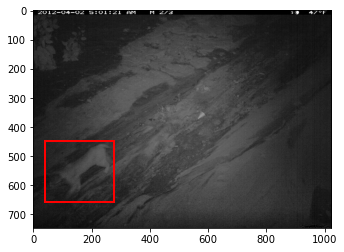

In [15]:
i = 500

boxes = [trans_val_ann['annotations'][j]['bbox'] for j in range(len(trans_val_ann['annotations'])) 
         if trans_val_ann['annotations'][j]['image_id']==trans_val_ann['images'][i]['id'] 
         and 'bbox' in trans_val_ann['annotations'][j].keys()]

img_path = os.path.join('eccv_18_all_images_sm', trans_val_ann['images'][i]['file_name']) # to change

image = read_image(img_path)

fig, ax = plt.subplots()
ax.imshow(image[0].squeeze(),cmap="gray")

scale_x = image.shape[2] / trans_val_ann['images'][i]['width'] 
scale_y = image.shape[1] / trans_val_ann['images'][i]['height']

boxes = torch.as_tensor(boxes)

for i in range(boxes.shape[0]):
  boxes[i][0] = torch.round(boxes[i][0] * scale_x)
  boxes[i][1] = torch.round(boxes[i][1] * scale_y)
  boxes[i][2] = torch.round(boxes[i][2] * scale_x)
  boxes[i][3] = torch.round(boxes[i][3] * scale_y)

  boxes[i][2] = boxes[i][0] + boxes[i][2]
  boxes[i][3] = boxes[i][1] + boxes[i][3]

target = {}
target["boxes"] = boxes

rect = patches.Rectangle((boxes[0][0], boxes[0][1]), boxes[0][2]-boxes[0][0], 
                         boxes[0][3]-boxes[0][1], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

In [16]:
image = Image.open(img_path).convert("RGB")
#image=conv(image)

In [17]:
image.size

(1024, 747)

In [18]:
conv = torchvision.transforms.ToTensor()

In [19]:
width, height = image.size[0], image.size[1]

In [20]:
width

1024

In [21]:
height

747

In [22]:
image_new = conv(image)

In [23]:
print(image_new.shape)

torch.Size([3, 747, 1024])


## Utils

In [24]:
# In paper :  ' ... and employ horizontal flipping for data augmentation. ( for detection)

import transforms as T   # from git hub repo

data_transform = {
    'train': T.RandomHorizontalFlip(0.5)}

In [25]:
def get_img_with_bbox(file_path):
  
  # returns a list with the idx of images with at least one bounding box (img_wbbox) and a list with the number of bbox for each valid image (num_bbox)
  file = json.load(open(file_path))
  img_wbbox=[]
  num_bbox=[]

  for i in range(len(file['images'])):
    bboxes= [file['annotations'][j]['bbox'] for j in range(len(file['annotations'])) if file['annotations'][j]['image_id']==file['images'][i]['id'] and 'bbox' in file['annotations'][j].keys()]

    if len(bboxes)!=0:
      img_wbbox.append(i)

      num_bbox.append(len(bboxes))

  return img_wbbox, num_bbox

In [26]:
class CustomImageDataset(Dataset):
    def __init__(self, label_path, img_dir, valid_img, transform= None, target_transform=None):
        self.label_file = json.load(open(label_path))
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.valid_img= valid_img

    def __len__(self):
        return len(self.valid_img)

    def __getitem__(self, idx):
        
        idx=self.valid_img[idx] # consider only images with bbox annotations
        img_path = os.path.join(self.img_dir, self.label_file['images'][idx]['file_name'])
        image = read_image(img_path)

        conv=torchvision.transforms.ToTensor()
        #if image.shape[0]==1:
        # some images have only one channel, we convert them to rgb
        image = Image.open(img_path).convert("RGB")
        image=conv(image)

        boxes= [self.label_file['annotations'][j]['bbox'] for j in range(len(self.label_file['annotations'])) if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]
        label= [self.label_file['annotations'][j]['category_id'] for j in range(len(self.label_file['annotations'])) if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]

        # transform bbox coords to adjust for resizing
        scale_x=image.shape[2]/self.label_file['images'][idx]['width'] 
        scale_y=image.shape[1]/self.label_file['images'][idx]['height']

        boxes=torch.as_tensor(boxes)
        for i in range(boxes.shape[0]):
          boxes[i][0]=torch.round(boxes[i][0]*scale_x)
          boxes[i][1]=torch.round(boxes[i][1]*scale_y)
          boxes[i][2]=torch.round(boxes[i][2]*scale_x)
          boxes[i][3]=torch.round(boxes[i][3]*scale_y)

          boxes[i][2]=boxes[i][0]+boxes[i][2] # to transform to pytorch bbox format
          boxes[i][3]=boxes[i][1]+boxes[i][3]

          #boxes[i][0]*=scale_x
          #boxes[i][1]*=scale_y
          #boxes[i][2]*=scale_x
          #boxes[i][3]*=scale_y

        label=torch.as_tensor(label)
        label=torch.where(label==30,0,1)  # 0 if empty (categ id = 30), 1 if animal
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = label
        target["image_id"] = image_id
        target['area']=area
        target['iscrowd']=iscrowd

        # TO DO : resize all to same size

        if self.transform:
          # transform image AND target
            image, target = self.transform(image, target)
        if self.target_transform:
            label = self.target_transform(label)

        return image, target


Example of use

In [27]:
train_valid_img,_ = get_img_with_bbox(train_ann_path)   # takes about 15sec to run on train data @kevin
cis_val_valid_img,_ = get_img_with_bbox(cis_val_ann_path)   # takes about 15sec to run on train data @kevin

In [ ]:
# def collate_fn(batch):
#     return tuple(zip(*batch))

In [30]:
training_data = CustomImageDataset(train_ann_path, img_folder, train_valid_img)
valid_data = CustomImageDataset(cis_val_ann_path, img_folder, cis_val_valid_img)

train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True, collate_fn=utils.collate_fn)
# In paper : ' We use a batch size of 1'

Target (Bbox) batch shape: torch.Size([1, 4])
Target (category) batch shape: torch.Size([1])
Label: animal


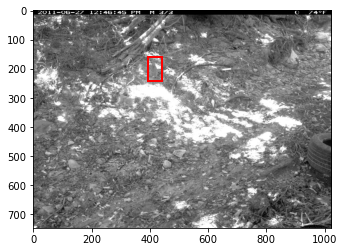

In [31]:
train_features, train_labels = next(iter(train_dataloader))
#print(f"Feature batch shape: {train_features.size()}")
print(f"Target (Bbox) batch shape: {train_labels[0]['boxes'].size()}")
print(f"Target (category) batch shape: {train_labels[0]['labels'].size()}")

img = train_features[0][0].squeeze()
label = train_labels[0]['labels']
label_categ='animal'

if label[0]==0:
  label_categ='background'

fig, ax = plt.subplots()
ax.imshow(img,cmap="gray")
rect = patches.Rectangle((train_labels[0]['boxes'][0][0], train_labels[0]['boxes'][0][1]), train_labels[0]['boxes'][0][2]-train_labels[0]['boxes'][0][0], train_labels[0]['boxes'][0][3]-train_labels[0]['boxes'][0][1], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
print(f"Label: {label_categ}")

##Horizontal flip debugging p2

In [32]:
# trans = data_transform['train']
# img2, target2 = trans(image, target)

# fig, ax = plt.subplots()
# ax.imshow(img2[0].squeeze(), cmap="gray")

# rect = patches.Rectangle((target2['boxes'][0][0], target2['boxes'][0][1]), 
#                          target2['boxes'][0][2] - target2['boxes'][0][0], 
#                          target2['boxes'][0][3] - target2['boxes'][0][1], 
#                          linewidth=2, edgecolor='r', facecolor='none')
# ax.add_patch(rect)

## Pre-trained model

In [33]:
# Inspired from https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/torchvision_finetuning_instance_segmentation.ipynb#scrollTo=YjNHjVMOyYlH

In [34]:
def get_model_from_pretrained(num_classes):

  # load an instance segmentation model pre-trained on COCO
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

  for param in model.parameters(): # to freeze all existing weights
    param.requires_grad = False

  # get the number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  return model

In [35]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.get_device_name(0)
# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_model_from_pretrained(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0003, momentum=0.9)

# like in the paper
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[5,10], gamma=0.1)

In [41]:
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True, collate_fn=utils.collate_fn)

In [42]:
trans_val_valid_img,_ = get_img_with_bbox(trans_val_ann_path)   # takes about 1min to run on train data
trans_valid_data = CustomImageDataset(trans_val_ann_path,img_folder, trans_val_valid_img)
trans_valid_dataloader = DataLoader(trans_valid_data, batch_size=10, shuffle=True, collate_fn=utils.collate_fn)

In [43]:
cis_val_valid_img,_ = get_img_with_bbox(cis_val_ann_path)   # takes about 1min to run on train data
cis_valid_data = CustomImageDataset(cis_val_ann_path,img_folder, cis_val_valid_img)
cis_valid_dataloader = DataLoader(cis_valid_data, batch_size=10, shuffle=True, collate_fn=utils.collate_fn)

In [44]:
# !!TO DO : replace this 'return coco_evaluator' by this 'return metric_logger' on line 
# #109 of engine.py in evaluate function and CTRL+S

In [45]:
# way around weird behav
# del evaluate
# from engine_modif import train_one_epoch, evaluate

In [77]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1080 Ti'

In [48]:
# TRAIN

all_train_logs = []
all_trans_valid_logs = []
all_cis_valid_logs = []

num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_logs = train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=100)
    all_train_logs.append(train_logs)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset

    for images, targets in trans_valid_dataloader: # can do batch of 10 prob.
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            trans_loss_dict = model(images, targets)
            trans_loss_dict = [{k: loss.to('cpu')} for k, loss in trans_loss_dict.items()]
            all_trans_valid_logs.append(trans_loss_dict)


    for images, targets in cis_valid_dataloader: # can do batch of 10 prob.
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            cis_loss_dict = model(images, targets)
            cis_loss_dict = [{k: loss.to('cpu')} for k, loss in cis_loss_dict.items()]
            all_cis_valid_logs.append(cis_loss_dict)

Epoch: [0]  [    0/12099]  eta: 0:28:50  lr: 0.000000  loss: 0.2531 (0.2531)  loss_classifier: 0.0989 (0.0989)  loss_box_reg: 0.1523 (0.1523)  loss_objectness: 0.0018 (0.0018)  loss_rpn_box_reg: 0.0001 (0.0001)  time: 0.1430  data: 0.0380  max mem: 3752
Epoch: [0]  [  100/12099]  eta: 0:25:45  lr: 0.000020  loss: 0.2541 (0.2558)  loss_classifier: 0.0960 (0.0996)  loss_box_reg: 0.1437 (0.1201)  loss_objectness: 0.0024 (0.0281)  loss_rpn_box_reg: 0.0026 (0.0081)  time: 0.1266  data: 0.0412  max mem: 3752
Epoch: [0]  [  200/12099]  eta: 0:25:17  lr: 0.000040  loss: 0.1933 (0.2486)  loss_classifier: 0.0784 (0.0955)  loss_box_reg: 0.0788 (0.1155)  loss_objectness: 0.0151 (0.0304)  loss_rpn_box_reg: 0.0018 (0.0071)  time: 0.1282  data: 0.0416  max mem: 3752
Epoch: [0]  [  300/12099]  eta: 0:25:02  lr: 0.000059  loss: 0.2304 (0.2447)  loss_classifier: 0.0926 (0.0923)  loss_box_reg: 0.1157 (0.1131)  loss_objectness: 0.0099 (0.0313)  loss_rpn_box_reg: 0.0030 (0.0080)  time: 0.1295  data: 0.0424

Epoch: [0]  [ 3300/12099]  eta: 0:18:03  lr: 0.000196  loss: 0.1128 (0.1881)  loss_classifier: 0.0377 (0.0645)  loss_box_reg: 0.0520 (0.0830)  loss_objectness: 0.0019 (0.0325)  loss_rpn_box_reg: 0.0025 (0.0080)  time: 0.1279  data: 0.0397  max mem: 3752
Epoch: [0]  [ 3400/12099]  eta: 0:17:51  lr: 0.000196  loss: 0.1297 (0.1871)  loss_classifier: 0.0416 (0.0641)  loss_box_reg: 0.0585 (0.0824)  loss_objectness: 0.0373 (0.0325)  loss_rpn_box_reg: 0.0039 (0.0081)  time: 0.1167  data: 0.0331  max mem: 3752
Epoch: [0]  [ 3500/12099]  eta: 0:17:38  lr: 0.000196  loss: 0.1168 (0.1864)  loss_classifier: 0.0404 (0.0639)  loss_box_reg: 0.0484 (0.0818)  loss_objectness: 0.0031 (0.0325)  loss_rpn_box_reg: 0.0043 (0.0081)  time: 0.1234  data: 0.0381  max mem: 3752
Epoch: [0]  [ 3600/12099]  eta: 0:17:24  lr: 0.000196  loss: 0.1444 (0.1857)  loss_classifier: 0.0476 (0.0637)  loss_box_reg: 0.0560 (0.0813)  loss_objectness: 0.0233 (0.0326)  loss_rpn_box_reg: 0.0039 (0.0081)  time: 0.1193  data: 0.0352

Epoch: [0]  [ 6600/12099]  eta: 0:11:23  lr: 0.000196  loss: 0.1140 (0.1709)  loss_classifier: 0.0388 (0.0584)  loss_box_reg: 0.0567 (0.0714)  loss_objectness: 0.0079 (0.0332)  loss_rpn_box_reg: 0.0023 (0.0079)  time: 0.1258  data: 0.0361  max mem: 3752
Epoch: [0]  [ 6700/12099]  eta: 0:11:11  lr: 0.000196  loss: 0.1532 (0.1706)  loss_classifier: 0.0502 (0.0583)  loss_box_reg: 0.0612 (0.0713)  loss_objectness: 0.0173 (0.0332)  loss_rpn_box_reg: 0.0042 (0.0078)  time: 0.1343  data: 0.0398  max mem: 3752
Epoch: [0]  [ 6800/12099]  eta: 0:10:59  lr: 0.000196  loss: 0.1450 (0.1702)  loss_classifier: 0.0466 (0.0581)  loss_box_reg: 0.0524 (0.0710)  loss_objectness: 0.0083 (0.0332)  loss_rpn_box_reg: 0.0032 (0.0079)  time: 0.1227  data: 0.0356  max mem: 3752
Epoch: [0]  [ 6900/12099]  eta: 0:10:47  lr: 0.000196  loss: 0.1350 (0.1699)  loss_classifier: 0.0404 (0.0580)  loss_box_reg: 0.0503 (0.0708)  loss_objectness: 0.0039 (0.0332)  loss_rpn_box_reg: 0.0024 (0.0079)  time: 0.1233  data: 0.0370

Epoch: [0]  [ 9900/12099]  eta: 0:04:30  lr: 0.000196  loss: 0.1167 (0.1639)  loss_classifier: 0.0427 (0.0557)  loss_box_reg: 0.0599 (0.0670)  loss_objectness: 0.0053 (0.0333)  loss_rpn_box_reg: 0.0017 (0.0079)  time: 0.1269  data: 0.0379  max mem: 3752
Epoch: [0]  [10000/12099]  eta: 0:04:18  lr: 0.000196  loss: 0.1211 (0.1637)  loss_classifier: 0.0318 (0.0556)  loss_box_reg: 0.0394 (0.0669)  loss_objectness: 0.0072 (0.0333)  loss_rpn_box_reg: 0.0030 (0.0079)  time: 0.1302  data: 0.0402  max mem: 3752
Epoch: [0]  [10100/12099]  eta: 0:04:05  lr: 0.000196  loss: 0.1390 (0.1636)  loss_classifier: 0.0568 (0.0556)  loss_box_reg: 0.0508 (0.0668)  loss_objectness: 0.0178 (0.0334)  loss_rpn_box_reg: 0.0015 (0.0079)  time: 0.1135  data: 0.0324  max mem: 3752
Epoch: [0]  [10200/12099]  eta: 0:03:53  lr: 0.000196  loss: 0.0945 (0.1634)  loss_classifier: 0.0302 (0.0555)  loss_box_reg: 0.0313 (0.0667)  loss_objectness: 0.0044 (0.0333)  loss_rpn_box_reg: 0.0017 (0.0079)  time: 0.1149  data: 0.0333

In [126]:
print(all_train_logs[0])

lr: 0.000196  loss: 0.0936 (0.1608)  loss_classifier: 0.0328 (0.0545)  loss_box_reg: 0.0396 (0.0651)  loss_objectness: 0.0033 (0.0333)  loss_rpn_box_reg: 0.0024 (0.0079)


In [127]:
len(all_train_logs)

1

In [129]:
len(all_trans_valid_logs)

154

In [131]:
print(all_cis_valid_logs[0])

[{'loss_classifier': tensor(0.0361)}, {'loss_box_reg': tensor(0.0472)}, {'loss_objectness': tensor(0.0536)}, {'loss_rpn_box_reg': tensor(0.0048)}]


In [149]:
all_train_logs[0].meters

defaultdict(utils.SmoothedValue,
            {'lr': <utils.SmoothedValue at 0x23d36642748>,
             'loss': <utils.SmoothedValue at 0x23d366e2888>,
             'loss_classifier': <utils.SmoothedValue at 0x23d25ccba08>,
             'loss_box_reg': <utils.SmoothedValue at 0x23d36717cc8>,
             'loss_objectness': <utils.SmoothedValue at 0x23d36643988>,
             'loss_rpn_box_reg': <utils.SmoothedValue at 0x23d366485c8>})

In [152]:
all_train_logs[0].meters['loss_classifier'].value

0.08557875454425812

In [151]:
all_train_logs[0].meters['loss'].value

0.17442281544208527

In [150]:
all_train_logs[0].meters['loss'].avg

0.10768063366413116

In [ ]:
# trans_valid_logs=evaluate(model, trans_valid_dataloader, device=device)

In [ ]:
# all_trans_valid_logs=[]
# all_trans_valid_logs.append(trans_valid_logs)

In [154]:
# all_trans_valid_logs[0].meters['loss'].value
all_trans_valid_logs[0][3]

{'loss_rpn_box_reg': tensor(0.0101)}

In [155]:
print(all_train_logs)
# print(all_train_logs[0])

In [156]:
for iou_type, coco_eval in all_cis_valid_logs.coco_eval.items():
    print("IoU metric: {}".format(iou_type))
    coco_eval.summarize()

AttributeError: 'list' object has no attribute 'coco_eval'

In [ ]:
cis_valid_logs.coco_eval['bbox']

In [98]:
all_train_logs[0].meters

defaultdict(utils.SmoothedValue,
            {'lr': <utils.SmoothedValue at 0x23d36642748>,
             'loss': <utils.SmoothedValue at 0x23d366e2888>,
             'loss_classifier': <utils.SmoothedValue at 0x23d25ccba08>,
             'loss_box_reg': <utils.SmoothedValue at 0x23d36717cc8>,
             'loss_objectness': <utils.SmoothedValue at 0x23d36643988>,
             'loss_rpn_box_reg': <utils.SmoothedValue at 0x23d366485c8>})

In [89]:
all_train_logs[0].meters['loss'].value

0.17442281544208527

In [90]:
print(all_train_logs[0].meters['loss'])

0.0936 (0.1608)


In [83]:
range(1)

range(0, 1)

AttributeError: 'list' object has no attribute 'meters'

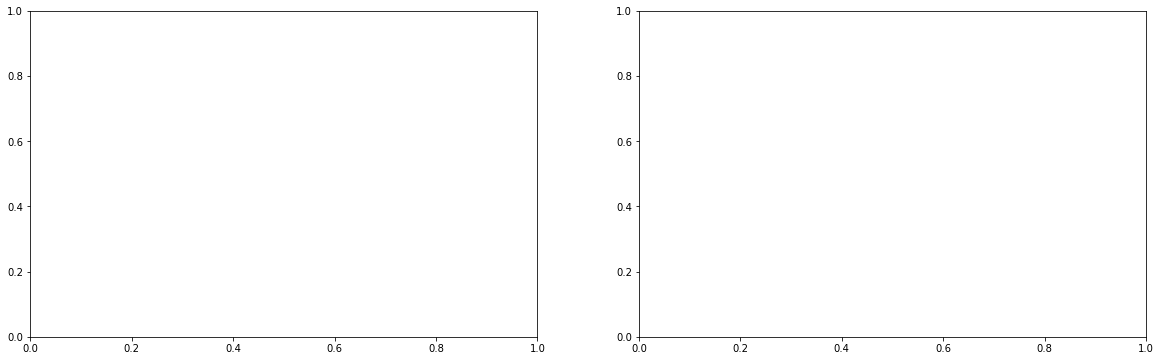

In [100]:
train_loss = []
train_loss_box_reg = []
cis_valid_loss = []
cis_valid_loss_box_reg = []
trans_valid_loss = []
trans_valid_loss_box_reg = []
fig, ax = plt.subplots(1,2, figsize=(20,6))

for i in range(1):
    train_loss.append(all_train_logs[i].meters['loss'].value)
    train_loss_box_reg.append(all_train_logs[i].meters['loss_box_reg'].value)

    trans_valid_loss.append(all_trans_valid_logs[i].meters['loss'].value)
    trans_valid_loss.append(all_trans_valid_logs[i].meters['loss_box_reg'].value)

    #cis_valid_loss.append(all_cis_valid_logs[i].meters['loss'].value)
    #cis_valid_loss_box_reg.append(all_cis_valid_logs[i].meters['loss_box_reg'].value)

ax[0].plot(np.arange(1),train_loss, label='train')
ax[0].plot(np.arange(1),trans_valid_loss, label='trans valid')
#ax[0].plot(np.arange(num_epochs),cis_valid_loss, label='cis valid')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend()

ax[1].plot(np.arange(num_epochs),train_loss_box_reg,label='train')
ax[1].set_ylabel('loss_box_reg')
ax[1].set_xlabel('epoch')

To obtain predicitons

In [ ]:
train_features, train_labels = next(iter(trans_valid_dataloader))
image=list(image.to(device) for image in train_features)

model.eval()
with torch.no_grad():
  pred=model(image)

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(24,16))

ax[0].imshow(train_features[0][0].squeeze(),cmap="gray")
rect = patches.Rectangle((train_labels[0]['boxes'][0][0], train_labels[0]['boxes'][0][1]), train_labels[0]['boxes'][0][2]-train_labels[0]['boxes'][0][0], train_labels[0]['boxes'][0][3]-train_labels[0]['boxes'][0][1], linewidth=2, edgecolor='r', facecolor='none')
ax[0].add_patch(rect)
ax[0].set_title('Ground truth')

ax[1].imshow(train_features[0][0].squeeze(),cmap="gray")
for i in range(len(pred[0]['boxes'])):
  rect = patches.Rectangle((pred[0]['boxes'][i][0].cpu(), pred[0]['boxes'][i][1].cpu()), (pred[0]['boxes'][i][2]-pred[0]['boxes'][i][0]).cpu(), (pred[0]['boxes'][i][3]-pred[0]['boxes'][i][1]).cpu(), linewidth=2, edgecolor='r', facecolor='none')
  ax[1].add_patch(rect)
ax[1].set_title('Pred')

#NMS
iou_threshold=0.005 # param to tune
boxes_to_keep=torchvision.ops.nms(pred[0]['boxes'],pred[0]['scores'],iou_threshold=iou_threshold).cpu()
ax[2].imshow(train_features[0][0].squeeze(),cmap="gray")
for i in boxes_to_keep:
  rect = patches.Rectangle((pred[0]['boxes'][i][0].cpu(), pred[0]['boxes'][i][1].cpu()), (pred[0]['boxes'][i][2]-pred[0]['boxes'][i][0]).cpu(), (pred[0]['boxes'][i][3]-pred[0]['boxes'][i][1]).cpu(), linewidth=2, edgecolor='r', facecolor='none')
  ax[2].add_patch(rect)

ax[2].set_title('After NMS')


In [ ]:
# ' For evaluation, we consider a detected box to be correct if its IoU≥ 0.5 with a ground truth box.'


In [ ]:
# doesnt seem to change something to do this before the MAP 
pred[0]['boxes']=pred[0]['boxes'][boxes_to_keep]
pred[0]['labels']=pred[0]['labels'][boxes_to_keep]
pred[0]['scores']=pred[0]['scores'][boxes_to_keep]

Metrics

In [ ]:
metric = MeanAveragePrecision( max_detection_thresholds=[2])
metric.update(pred, list(train_labels))
from pprint import pprint
pprint(metric.compute())

In [ ]:
model.roi_heads # original roi heads

In [ ]:
# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (animal) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
# We would prob need to change the size in 
# Resize(min_size=(800,), max_size=1333, mode='bilinear')


## CEt Ligne est ecrit par Abdiel
## Celle-ci est écrite par Kevin.

# As well as the output size in the fc of the FastRCNN Predictor
#(cls_score): Linear(in_features=1024, out_features=91, bias=True)
#(bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
